In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
% matplotlib inline

In [3]:
id_list=pd.read_csv('gender_submission.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### EDA on Cabin and Gender
##### A lot of missing data in 'Cabin'
##### Gender should be a main factor because of the gentlemen's spirit

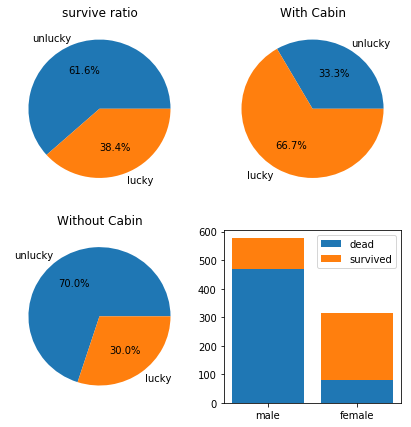

In [6]:
f, (ax1, ax2) = plt.subplots(2, 2,figsize=(7,7))
ax1[0].pie(train['Survived'].value_counts(),labels=['unlucky','lucky'],autopct='%1.1f%%')
ax1[0].set_title('survive ratio')
ax1[1].pie(train['Survived'][train['Cabin'].notnull()].value_counts().sort_index(),labels=['unlucky','lucky'],autopct='%1.1f%%')
ax1[1].set_title('With Cabin')
ax2[0].pie(train['Survived'][train['Cabin'].isnull()].value_counts().sort_index(),labels=['unlucky','lucky'],autopct='%1.1f%%')
ax2[0].set_title('Without Cabin')
male=train['Survived'][train['Sex']=='male'].value_counts().sort_index()
female=train['Survived'][train['Sex']=='female'].value_counts().sort_index()
survive=(male[1],female[1])
not_survive=(male[0],female[0])
ind=['male','female']
p1=plt.bar(ind,not_survive)
p2=plt.bar(ind,survive,bottom=not_survive)
ax2[1]=plt.legend((p1[0],p2[0]),('dead','survived'))


### Estimate the Age Column

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


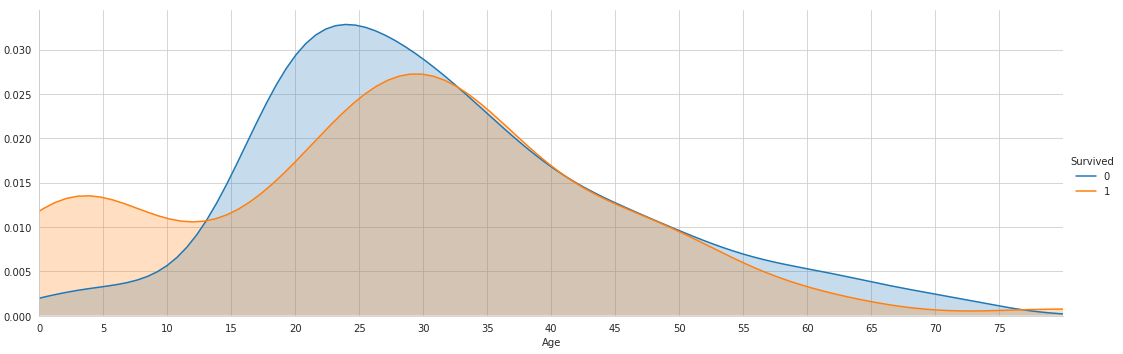

In [7]:
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(train[train['Sex']=='male'], hue='Survived', height=5, aspect=3)
    g.map(sns.kdeplot, 'Age',shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Age'].max(), 5), xlim=(0, train['Age'].max()))

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


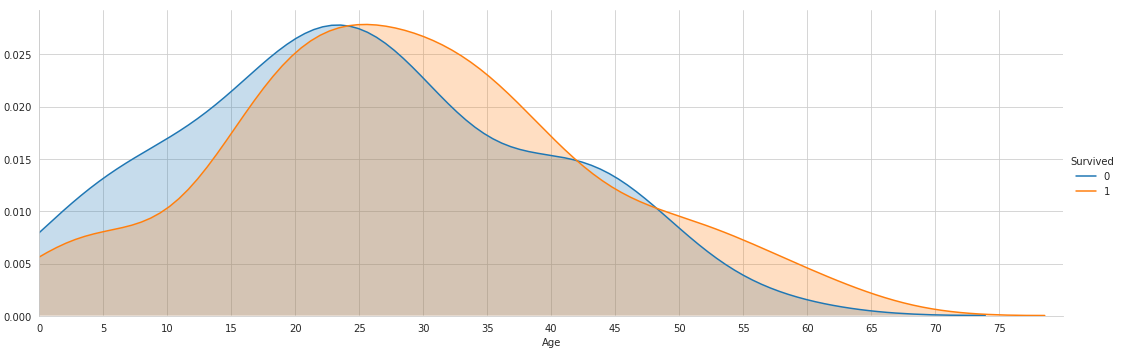

In [8]:
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(train[train['Sex']=='female'], hue='Survived', height=5, aspect=3)
    g.map(sns.kdeplot, 'Age',shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Age'].max(), 5), xlim=(0, train['Age'].max()))

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


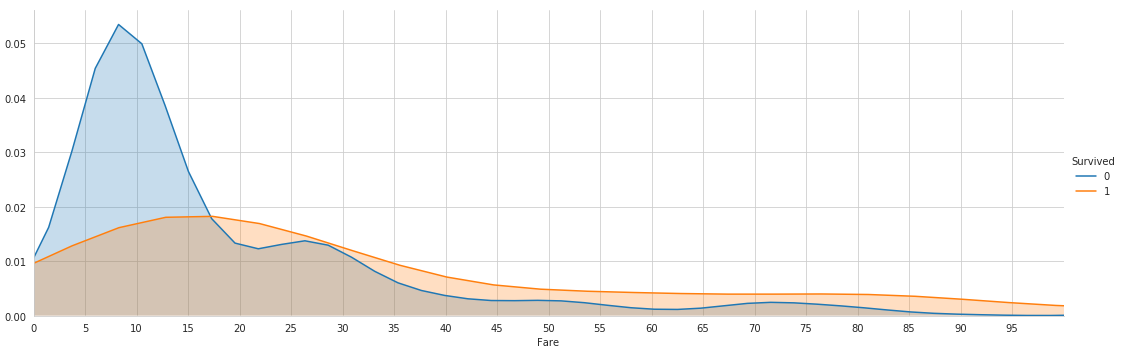

In [9]:
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=3)
    g.map(sns.kdeplot, 'Fare',shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, 100, 5), xlim=(0, 100))

### Age is also an important factor and estimation needed.


In [10]:
gender=pd.get_dummies(train['Sex'])
train=pd.concat([train,gender],axis=1)
test_gender=pd.get_dummies(test['Sex'])
test=pd.concat([test,test_gender],axis=1)
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,0


In [11]:
train['Title']=train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title']=test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

print(train['Title'].value_counts(),test['Title'].value_counts())

#Master: boys under 8 years old (google)

#Group Ms with Miss

#Others assigned to rare

train['Title'].replace(to_replace=['Mlle', 'Ms'], value='Miss', inplace=True)
train['Title'].replace(to_replace=['Lady','Mme'], value='Mrs', inplace=True)

test['Title'].replace(to_replace=['Mlle', 'Ms'], value='Miss', inplace=True)
test['Title'].replace(to_replace=['Lady','Mme'], value='Mrs', inplace=True)

train['Title'].replace(to_replace=['Rev', 'Dr','Col','Major','Jonkheer','Capt','the Countess','Don','Sir','Dona'], value='Rare', inplace=True)
test['Title'].replace(to_replace=['Rev', 'Dr','Col','Major','Jonkheer','Capt','the Countess','Don','Sir','Dona'], value='Rare', inplace=True)

train_title=pd.get_dummies(train['Title'])
test_title=pd.get_dummies(test['Title'])

train=pd.concat([train,train_title],axis=1)
test=pd.concat([test,test_title],axis=1)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Mme               1
Sir               1
Ms                1
Jonkheer          1
Don               1
Capt              1
Lady              1
the Countess      1
Name: Title, dtype: int64 Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Title, dtype: int64


In [12]:
age_train=train.loc[train['Age'].notnull()]
age_nan=train.loc[train['Age'].isnull()]
age_y=age_train['Age']
age_x=age_train[['Fare']+['Parch']+['SibSp']+['Pclass']+['female']+['Mr']+['Mrs']+['Miss']+['Master']+['Rare']]
nan=age_nan[['Fare']+['Parch']+['SibSp']+['Pclass']+['female']+['Mr']+['Mrs']+['Miss']+['Master']+['Rare']]
age_model=RandomForestRegressor(n_estimators = 1000, n_jobs = -1)

In [13]:
age_model.fit(age_x,age_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [14]:
print(age_model.score(age_x,age_y))

0.7301008570204197


In [15]:
train['Age'].loc[train['Age'].isnull()]=age_model.predict(nan)

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
test_nan=test.loc[test['Age'].isnull()]
nan_age=test_nan[['Fare']+['Parch']+['SibSp']+['Pclass']+['female']+['Mr']+['Mrs']+['Miss']+['Master']+['Rare']]
test['Age'].loc[test['Age'].isnull()]=age_model.predict(nan_age)

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Age estimation completed
### Feature Engineering on pclass sibsp embarked cabin fare 

In [17]:
test['Cabin'].loc[test['Cabin'].isnull()]=0
test['Cabin'].loc[test['Cabin']!=0]=1

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
train['Cabin'].loc[train['Cabin'].isnull()]=0
train['Cabin'].loc[train['Cabin']!=0]=1

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male,Title,Master,Miss,Mr,Mrs,Rare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,0,S,0,1,Mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,1,C,1,0,Mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,0,S,1,0,Miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,1,S,1,0,Mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,0,S,0,1,Mr,0,0,1,0,0
5,6,0,3,"Moran, Mr. James",male,24.092374,0,0,330877,8.4583,0,Q,0,1,Mr,0,0,1,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,1,S,0,1,Mr,0,0,1,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,0,S,0,1,Master,1,0,0,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,0,S,1,0,Mrs,0,0,0,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,0,C,1,0,Mrs,0,0,0,1,0


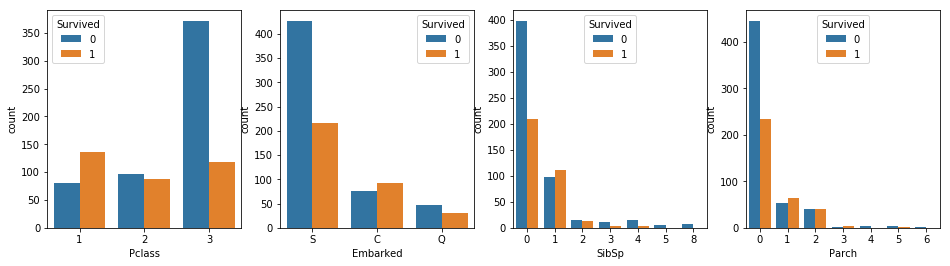

In [20]:
f, (ax3) = plt.subplots(1, 4,figsize=(16,4))
sns.countplot(x='Pclass', hue='Survived', data=train,ax=ax3[0])
sns.countplot(x='Embarked', hue='Survived', data=train,ax=ax3[1])
sns.countplot(x='SibSp', hue='Survived', data=train,ax=ax3[2])
sns.countplot(x='Parch', hue='Survived', data=train,ax=ax3[3])

 Pclass remains 3 classes,also more representative than fare because some people bought first class ticket with lower price.
 
Embarked divided to S and NonS

 SibSp divided to 3 classes: 0, 1-2, >3 
 
 Parch divided to 0,1

In [21]:
train['Embarked'].loc[train['Embarked']=='S']=1
test['Embarked'].loc[test['Embarked']=='S']=1
train['Embarked'].loc[train['Embarked']!=1]=0
test['Embarked'].loc[test['Embarked']!=1]=0

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
train['SibSp'].loc[train['SibSp']==1]=1
train['SibSp'].loc[train['SibSp']==2]=1
train['SibSp'].loc[train['SibSp']>2]=2

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
test['SibSp'].loc[test['SibSp']==1]=1
test['SibSp'].loc[test['SibSp']==2]=1
test['SibSp'].loc[test['SibSp']>2]=2

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
train['Parch'].loc[train['Parch']!=0]=1
test['Parch'].loc[test['Parch']!=0]=1

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
train.drop(['Fare'],axis=1)
test.drop(['Fare'],axis=1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,female,male,Title,Master,Miss,Mr,Mrs,Rare
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,0,0,0,1,Mr,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,0,1,1,0,Mrs,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,0,0,0,1,Mr,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,0,1,0,1,Mr,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,0,1,1,0,Mrs,0,0,0,1,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.000000,0,0,7538,0,1,0,1,Mr,0,0,1,0,0
6,898,3,"Connolly, Miss. Kate",female,30.000000,0,0,330972,0,0,1,0,Miss,0,1,0,0,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.000000,1,1,248738,0,1,0,1,Mr,0,0,1,0,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.000000,0,0,2657,0,0,1,0,Mrs,0,0,0,1,0
9,901,3,"Davies, Mr. John Samuel",male,21.000000,1,0,A/4 48871,0,1,0,1,Mr,0,0,1,0,0


In [26]:
from sklearn.cluster import KMeans

In [27]:
bin_num=4
kmeans_model=KMeans(n_clusters=bin_num)
kmeans_model.fit(train[[ 'Age', 'Survived']].dropna())
kmeans_model.cluster_centers_

array([[34.7702365 ,  0.3812709 ],
       [ 5.75184543,  0.55172414],
       [52.80956186,  0.36764706],
       [22.54588238,  0.35230352]])

In [28]:
h = 0.01
x_min, x_max=train['Age'].min()-h, train['Age'].max()+h
y_min, y_max=train['Survived'].min()-h, train['Survived'].max()+h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [29]:
result=kmeans_model.predict(np.c_[xx.ravel(), yy.ravel()])
result=result.reshape(xx.shape)

In [30]:
print(xx[result==0].min())
print(xx[result==0].max())
print(xx[result==1].min())
print(xx[result==1].max())
print(xx[result==2].min())
print(xx[result==2].max())
print(xx[result==3].min())
print(xx[result==3].max())

28.660000000000025
43.790000000000035
0.41
14.150000000000013
43.790000000000035
80.01000000000006
14.150000000000013
28.650000000000023


In [31]:
age_bin_list=[0,13.78,28.73,44.25,np.inf]
dataset=pd.concat([train, test], sort=True)

In [32]:
dataset['AgeBand']=pd.cut(dataset['Age'], age_bin_list)

In [33]:
age_bin=pd.get_dummies(dataset['AgeBand'])

In [34]:
age_bin.columns=['bin1','bin2','bin3','bin4']

In [35]:
dataset=pd.concat([dataset,age_bin],axis=1)

In [36]:
dataset=dataset.drop(['Age','AgeBand','Fare'],axis=1)

In [37]:
family_name=dataset['Name'].apply(lambda x: x.split(',')[0])

In [38]:
ticket=dataset['Ticket']
dataset['fusion']=(family_name.astype(str)+' '+dataset['Pclass'].astype(str)+' '+ticket.astype(str)+' '+dataset['Embarked'].astype(str))

In [39]:
def fusion_group_size(group):
    group_elements = dataset.loc[dataset['fusion'] == group, 'PassengerId']
    if len(group_elements) == 1:
        return 0
    else:
        return len(group_elements)
def fusion_group_id(group):
    group_elements = dataset.loc[dataset['fusion'] == group, 'PassengerId']
    if len(group_elements) == 1:
        return 0
    else:
        return group_elements.min()
dataset['Group'] = dataset['fusion'].apply(fusion_group_size)
dataset['GroupID'] = dataset['fusion'].apply(fusion_group_id)
dataset=dataset.drop(['fusion'],axis=1)

In [40]:
dataset=dataset.drop(['Ticket'],axis=1)

In [41]:
train=dataset.iloc[:891]
test=dataset.iloc[891:]

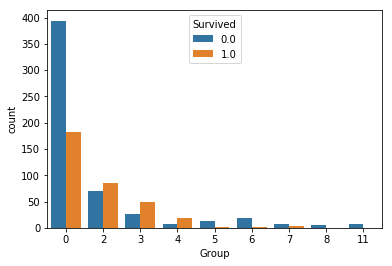

In [42]:
sns.countplot(x='Group', hue='Survived', data=train)

In [43]:
dataset

,Cabin,Embarked,Master,Miss,Mr,Mrs,Name,Parch,PassengerId,Pclass,...,Survived,Title,female,male,bin1,bin2,bin3,bin4,Group,GroupID
0,0,1,0,0,1,0,"Braund, Mr. Owen Harris",0,1,3,...,0.0,Mr,0,1,0,1,0,0,0,0
1,1,0,0,0,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,...,1.0,Mrs,1,0,0,0,1,0,2,2
2,0,1,0,1,0,0,"Heikkinen, Miss. Laina",0,3,3,...,1.0,Miss,1,0,0,1,0,0,0,0
3,1,1,0,0,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,...,1.0,Mrs,1,0,0,0,1,0,2,4
4,0,1,0,0,1,0,"Allen, Mr. William Henry",0,5,3,...,0.0,Mr,0,1,0,0,1,0,0,0
5,0,0,0,0,1,0,"Moran, Mr. James",0,6,3,...,0.0,Mr,0,1,0,1,0,0,0,0
6,1,1,0,0,1,0,"McCarthy, Mr. Timothy J",0,7,1,...,0.0,Mr,0,1,0,0,0,1,0,0
7,0,1,1,0,0,0,"Palsson, Master. Gosta Leonard",1,8,3,...,0.0,Master,0,1,1,0,0,0,5,8
8,0,1,0,0,0,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,9,3,...,1.0,Mrs,1,0,0,1,0,0,3,9
9,0,0,0,0,0,1,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,...,1.0,Mrs,1,0,0,1,0,0,2,10


In [44]:
dataset['Group'].loc[(dataset['Group']==2) | (dataset['Group']==3) | (dataset['Group']==4)]=1

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
dataset['Group'].loc[dataset['Group']>4]=2

C:\Users\shuoyan001\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


According to reference women-child group always shared same fate.

In [46]:
dataset['Title'] = dataset['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])

# Create a mask to account only for females or boys in groups
mask = (dataset['GroupID'] != 0) & ((dataset['Title'] == 'Master') | (dataset['Sex'] == 'female'))

# Get the number of females and boys in each group, discard groups with only one member
wcg_groups = dataset.loc[mask, 'GroupID'].value_counts()
wcg_groups = wcg_groups[wcg_groups > 1]

# Update the mask to discard groups with only one female or boy
mask = mask & (dataset['GroupID'].isin(wcg_groups.index))

# Create the new feature using the updated mask
dataset['InWcg'] = 0
dataset.loc[mask, 'InWcg'] = 1

print("Number of woman-child-groups found:", len(wcg_groups))
print("Number of passengers in woman-child-groups:", len(dataset.loc[dataset['InWcg'] == 1]))

Number of woman-child-groups found: 75
Number of passengers in woman-child-groups: 209


In [47]:
dataset.drop(columns=['Name','Title','GroupID','PassengerId','Sex','female'],inplace=True)

In [48]:
train=dataset.iloc[:891]
test=dataset.iloc[891:]

In [49]:
train_label=train['Survived']
train=train.drop(['Survived'],axis=1)
test=test.drop(['Survived'],axis=1)

In [56]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [58]:
class t_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(t_net , self).__init__()
        self.linear_layer = nn.Linear(input_size,30)
        self.hd=nn.ModuleList([nn.Sequential(nn.Linear(30,30),nn.ReLU()) for i in range(10)])
        self.hidden = nn.Sequential(*self.hd)
        self.output = nn.Linear(30,output_size)
    def forward(self, x):
        x=nn.ReLU()(self.linear_layer(x))
        x=self.hidden.forward(x)
        scores=self.output(x)
        return scores

In [59]:
net=t_net(17,1)
print(net)

t_net(
  (linear_layer): Linear(in_features=17, out_features=30, bias=True)
  (hd): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (7): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
    )
    (8): Sequential(
      (0): Linear(in_featur

In [60]:
# make the criterion
criterion = nn.BCEWithLogitsLoss()

# make the SGD optimizer. 
optimizer=torch.optim.RMSprop(net.parameters(),lr=0.001)

# set up the batch size   
bs=50

In [67]:
x_train=torch.Tensor(train.values)
x_test=torch.Tensor(test.values)
x_label=torch.FloatTensor(np.array(train_label.values.astype(int))).unsqueeze_(-1)

In [72]:
for iter in range(1,25000):
    optimizer.zero_grad()
    # Set dL/dU, dL/dV, dL/dW to be filled with zeros
    indices=torch.LongTensor(bs).random_(0,891)
    batch_data=x_train[indices]
    batch_label=x_label[indices]
    # create a minibatch
    inputs=batch_data.view(bs,17)
    
    
    # reshape the minibatch
    inputs.requires_grad_()
    
    # tell Pytorch to start tracking all operations that will be done on "inputs"
    scores=net(inputs)
    # forward the minibatch through the net  
    loss=criterion(scores,batch_label)
    
    # Compute the average of the losses of the data points in the minibatch

    loss.backward()
    # backward pass to compute dL/dU, dL/dV and dL/dW    

    optimizer.step()

In [87]:
a=torch.sigmoid(net(x_test))>0.5

In [93]:
submit_test=pd.read_csv('test.csv')
submission = pd.DataFrame({'PassengerId': submit_test['PassengerId'], 'Survived': np.array(a).flatten()})
submission.to_csv("submission.csv", index=False)

In [94]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
